<a href="https://colab.research.google.com/github/nicolai5965/K-means-clustering-on-SeedsData/blob/main/K_mean_SeedsData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
drive.mount('/content/drive') 


Mounted at /content/drive


In [2]:
def load_data(filename): # load_data(): Loads dataset from a file using delimiter.
    return np.loadtxt(filename, delimiter=',')


In [3]:
def normalize_data(data): # normalize_data(): Normalizes data using z-score normalization.
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    return (data - data_mean) / data_std


def init_centroids(data, k): # init_centroids(): Initializes K random centroids from data.
    return data[np.random.randint(len(data), size=k)]


def k_means_clustering(data, centroids, max_iters=5): # k_means_clustering(): Executes K-means clustering algorithm.
    for _ in range(max_iters):
        clusters = assign_clusters(data, centroids)
        centroids = update_centroids(data, clusters)
    return clusters, centroids

In [4]:
def assign_clusters(data, centroids): # assign_clusters(): Assigns data points to nearest centroids.
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


def update_centroids(data, clusters): # update_centroids(): Updates centroids based on cluster means.
    return np.array([np.mean(data[clusters == i], axis=0) for i in range(len(np.unique(clusters)))])


def perform_pca(data): # perform_pca(): Performs Principal Component Analysis on data.
    centered_data = (data.T - np.mean(data, 1))
    eig_values, eig_vectors = np.linalg.eigh(np.cov(centered_data.T))
    eig_values = np.flip(eig_values, 0)
    eig_vectors = np.flip(eig_vectors, 1)
    return eig_values, eig_vectors

In [5]:
def transform_data(features, eig_vectors): # transform_data(): Transforms data using top eigenvectors.
    return np.dot(features, eig_vectors[:, 0:2])


def generate_colors(n): # generate_colors(): Generates n unique colors for plotting.
    cmap = plt.cm.get_cmap('viridis', n)
    colors = [cmap(i) for i in range(n)]
    return colors

In [7]:
def calculate_inertia(data, centroids, clusters): # calculate_inertia(): Calculates inertia for given clusters.
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster_data = data[clusters == i]
        distances = np.linalg.norm(cluster_data - centroid, axis=1)
        inertia += np.sum(distances ** 2)
    return inertia

def find_optimal_k(data, max_k): # find_optimal_k(): Finds optimal K using Elbow Method.
    inertias = []

    for k in range(1, max_k + 1):
        centroids = init_centroids(data, k)
        clusters, centroids = k_means_clustering(data, centroids)
        inertia = calculate_inertia(data, centroids, clusters)
        inertias.append(inertia)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), inertias, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.show()
    return inertias


def get_optimal_k(inertias): # get_optimal_k(): Returns optimal K from calculated inertias.
    deltas = np.diff(inertias)
    deltas_ratio = np.diff(deltas) / deltas[:-1]
    indices = np.argwhere(deltas_ratio > 0.5)
    
    if indices.size == 0:
        # Return the index of the largest ratio
        return np.argmax(deltas_ratio) + 2
    else:
        return indices[0][0] + 2


In the dataset I found that the last column where the cluster targets, so I have made code which tries to find the optimal k and where it us just using the cluster amount from the targets. 

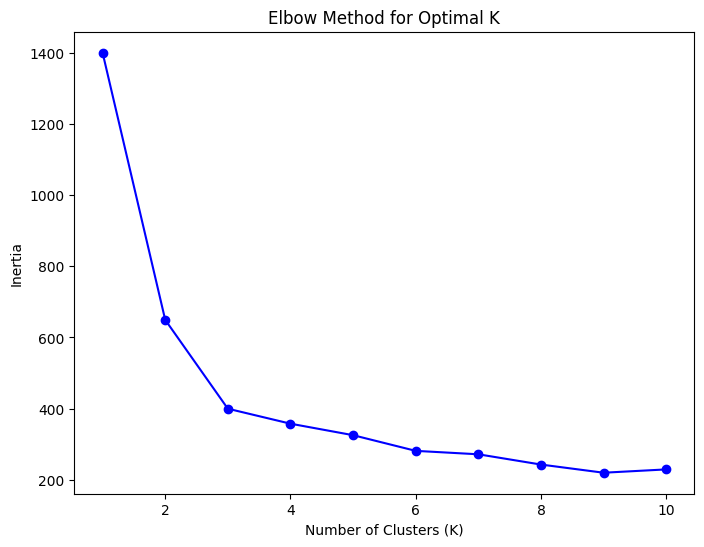

In [8]:
# Load and preprocess data
filename = '/content/drive/My Drive/Colab Notebooks/seedsDataset.txt'
data = load_data(filename)
labels = data[:, -1]
features = data[:, :-1]
norm_data = normalize_data(features)
inertias = find_optimal_k(norm_data, max_k=10)
optimal_k = get_optimal_k(inertias)

In [9]:
# Perform K-means clustering
max_iters = 10

# Perform K-means clustering with optimal K
initial_centroids = init_centroids(norm_data, 3)
clusters, centroids = k_means_clustering(norm_data, initial_centroids, max_iters=max_iters)

# Label the data
labeled_data = np.column_stack((data, clusters))

# Save labeled data to a file
np.savetxt('labeled_data.csv', labeled_data, delimiter=',', fmt='%f')

# Perform PCA on the dataset and each cluster
eig_values, eig_vectors = perform_pca(data.T)
data_2D = transform_data(data, eig_vectors)

# Create 2D representation of clusters
cluster_data_2D = [data_2D[clusters == i] for i in range(3)]


In [10]:
def plot_clusters(cluster_data_2D, title='Clusters', xlabel='PC1', ylabel='PC2', figsize=(8, 6)): # plot_clusters(): Plots 2D representation of clustered data.
    plt.figure(figsize=figsize)
    colors = generate_colors(len(cluster_data_2D))
    for i, cluster in enumerate(cluster_data_2D):
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i], label=f"Cluster {i + 1}")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

<ipython-input-5-0d4f15709154>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n)


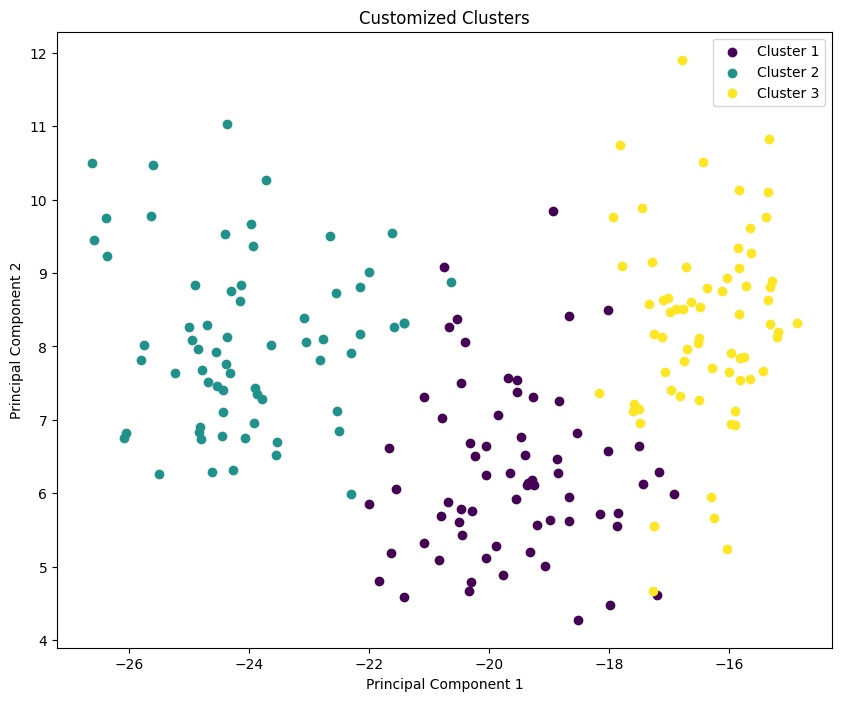

In [11]:
# Plot the clusters
plot_clusters(cluster_data_2D, title='Customized Clusters', xlabel='Principal Component 1', ylabel='Principal Component 2', figsize=(10, 8))


In [12]:
from sklearn.metrics import adjusted_rand_score # adjusted_rand_score(): Calculates Adjusted Rand Index for evaluation.

ari = adjusted_rand_score(labels, clusters) 
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.8023


In [13]:
# Perform K-means clustering with optimal K
initial_centroids = init_centroids(norm_data, optimal_k)
clusters, centroids = k_means_clustering(norm_data, initial_centroids, max_iters=max_iters)

# Label the data
labeled_data = np.column_stack((data, clusters))

# Save labeled data to a file
np.savetxt('labeled_data.csv', labeled_data, delimiter=',', fmt='%f')

# Perform PCA on the dataset and each cluster
eig_values, eig_vectors = perform_pca(data.T)
data_2D = transform_data(data, eig_vectors)

# Create 2D representation of clusters
cluster_data_2D = [data_2D[clusters == i] for i in range(optimal_k)]

<ipython-input-5-0d4f15709154>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n)


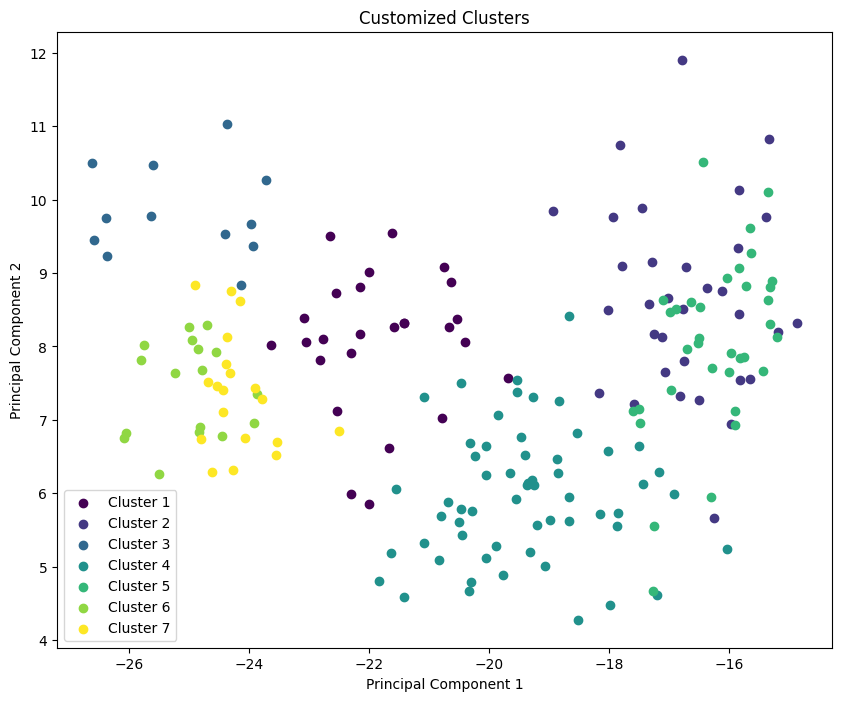

In [14]:
# Plot the clusters
plot_clusters(cluster_data_2D, title='Customized Clusters', xlabel='Principal Component 1', ylabel='Principal Component 2', figsize=(10, 8))


In [15]:
ari = adjusted_rand_score(labels, clusters)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.4503
